In [1]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 500
M = 20

In [4]:
# from sklearn.cluster import KMeans
# from munkres import Munkres
# from sklearn.metrics.pairwise import cosine_similarity

# def reference_comms(num_states, X):
#     X = np.concatenate(X, axis=-1)
#     kmeans = KMeans(
#         n_clusters=num_states, 
#         init='k-means++', n_init=50,
#         random_state=74
#     ).fit(X=X.T)
#     print('found reference')
#     return kmeans.cluster_centers_.T # num_rois x num_comms

# def align_two_partitions(source_comms, target_comms):
#     # align source onto target
    
#     # distatnce matrix
#     Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
#     # Hungarian permutation method
#     best_pi = list(zip(*Munkres().compute(Dd)))[1]
#     source_comms = source_comms[:, best_pi]
#     return source_comms, best_pi

# def align_partitions(num_states, X):
#     comm_cntrs = reference_comms(num_states, X)
#     best_pis = []
#     for idx, comms in tqdm(enumerate(X)):
#         _, best_pi = align_two_partitions(
#             source_comms=comms, 
#             target_comms=comm_cntrs
#         )
#         best_pis.append(best_pi)
#     return best_pis

# def get_attractors(idx_resample):
#     if idx_resample<=100:
#         with open(f'/media/joyneelm/joy_backup/slds/moving_circles/bootstrap_resamples/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#             model,_,_,_ = pickle.load(f)
#     elif idx_resample>100:
#         with open(f'/media/joyneelm/joy_backup/slds/moving_circles/bootstrap_resamples/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#             model,_,_,_ = pickle.load(f)
#     As = model.dynamics.As
#     bs = model.dynamics.bs
#     C = model.emissions.Cs[0]
#     d = model.emissions.ds[0]
#     attractors = np.zeros((K,N))
#     for k in range(K):
#         attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
#     attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
#     return attractors.T

# all_attractors = []    
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     all_attractors.append(get_attractors(idx_resample))

# all_perms = align_partitions(K,all_attractors)

In [5]:
# def get_df(idx_resample,perm):
#     if idx_resample<=100:
#         with open(f'/media/joyneelm/joy_backup/slds/moving_circles/bootstrap_resamples/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#             model,q,elbos,resampled_subj_list = pickle.load(f)
#     elif idx_resample>100:
#         with open(f'/media/joyneelm/joy_backup/slds/moving_circles/bootstrap_resamples/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
#             model,q,elbos,resampled_subj_list = pickle.load(f)
#     # with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
        
#     model.permute(perm)
#     model.permute(np.array([1,2,4,3,5,0]))
    
#     resampled_df = []
#     for pid in resampled_subj_list:
#         resampled_df.append(orig_df[orig_df['pid']==pid])
#     resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)
#     df = resampled_df

#     df['continuous_states'] = [None]*df.shape[0]
#     df['discrete_states'] =[None]*df.shape[0]
#     hrflag=0
#     prox_bins = list(np.arange(M//2)/(M//2))[1:]
#     dir_bins = [0]
#     nprox = len(prox_bins)+1
#     ndir = len(dir_bins)+1
#     for idx_row in range(df.shape[0]):
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         proxd = np.digitize(prox, bins=prox_bins)
#         dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
#         stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
#         input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

#         y = df.loc[idx_row]['timeseries']
#         x = q.mean_continuous_states[idx_row]
#         z = model.most_likely_states(x,y,input=input)
#         df.at[idx_row,'continuous_states'] = x
#         df.at[idx_row,'discrete_states'] = z
#         prox = df.loc[idx_row]['proximity']
#         prox = prox - prox.min()
#         prox = prox / prox.max()
#         df.at[idx_row,'proximity'] = prox
    
#     return df,model

In [6]:
# all_dfs = {}
# all_models = {}
# for idx_resample in tqdm(range(1,num_resamples+1)):
#     all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))
with open(f'pkl/all_dfs_models_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    all_dfs,all_models = pickle.load(f)

In [7]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)

In [8]:
def get_attractor(model,df):
    attractors = np.zeros((K,N))
    for idx_state in range(K):
        A = model.dynamics.As[idx_state]
        b = model.dynamics.bs[idx_state]
        C = model.emissions.Cs[0]
        d = model.emissions.ds[0]
        attractor = np.linalg.inv(np.eye(D)-A) @ b
        attractor_roi = C @ attractor + d
        attractors[idx_state,:] = attractor_roi
    return attractors

In [9]:
all_attractors = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    attractors = get_attractor(all_models[idx_resample],all_dfs[idx_resample])
    state_mask = state_masks[idx_resample]
    for idx_state in range(K):
        if state_mask[idx_state] == 1:
            attractors[idx_state] = np.nan
    all_attractors[idx_resample] = attractors
all_attractors = np.stack(all_attractors.values())
res = scipy.stats.ttest_1samp(all_attractors, popmean=0, axis=0, nan_policy='omit', alternative='two-sided', keepdims=False)
mask = res.pvalue < (0.05)/(K*N)
avg_attractors = np.nanmean(all_attractors,axis=0)
avg_attractors[~mask] = 0

100%|██████████| 500/500 [00:00<00:00, 4650.30it/s]


1.0076240503167366
0.9867038138811088
0.533839105095082
0.8549028271358795
0.5422192496871402
0.17582835830965782


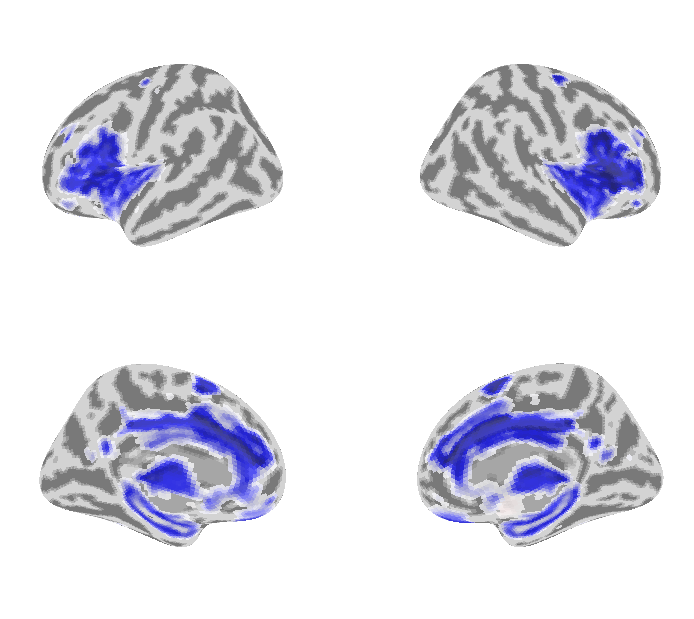

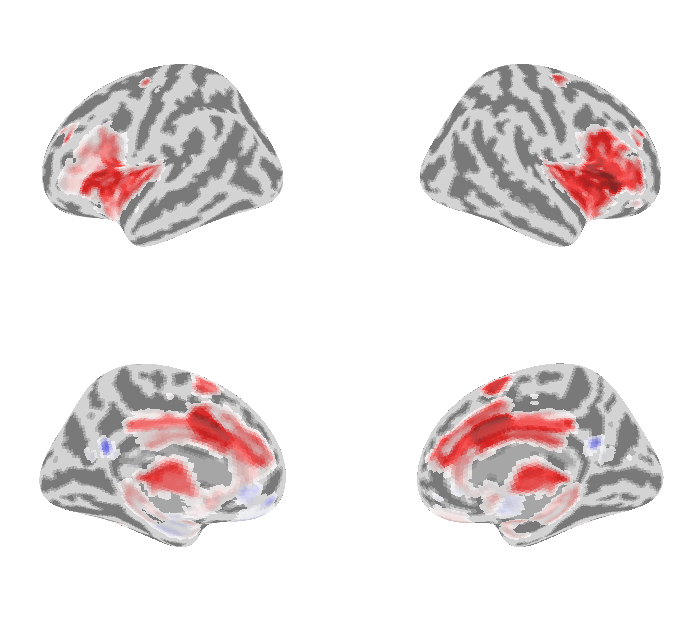

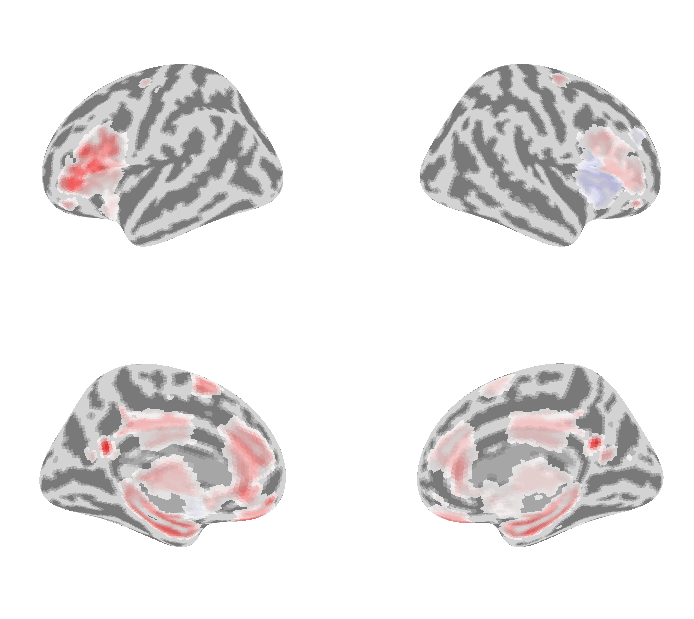

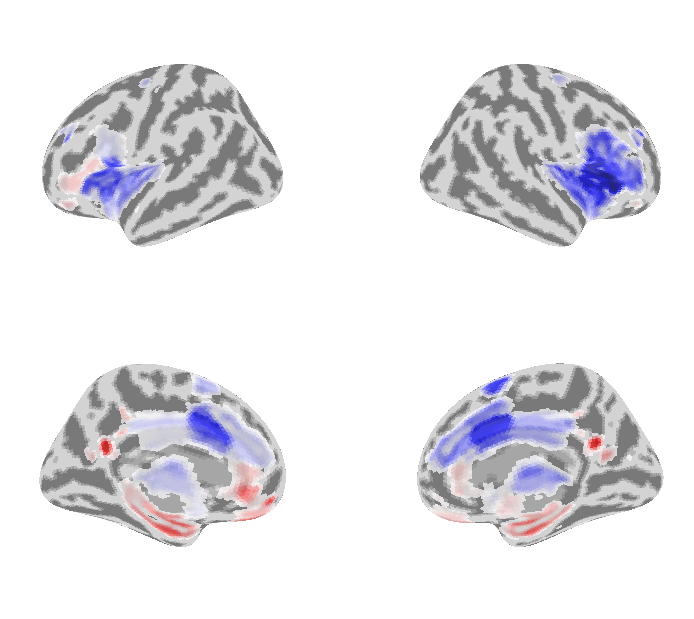

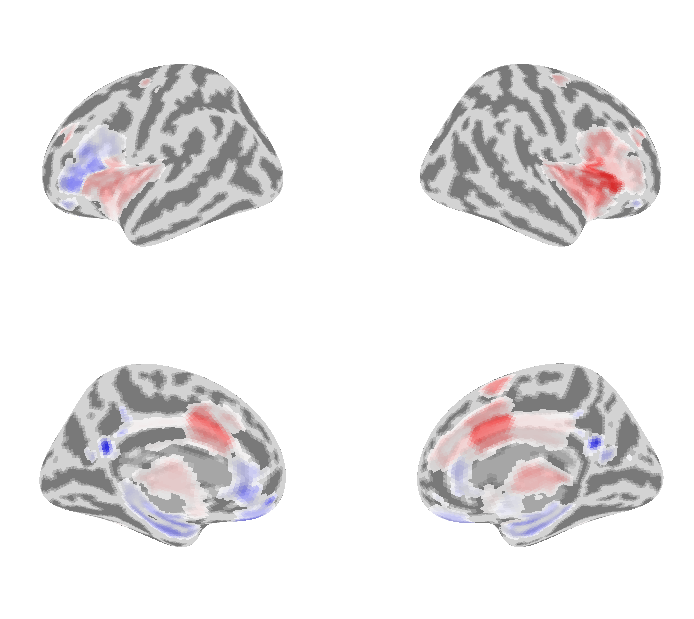

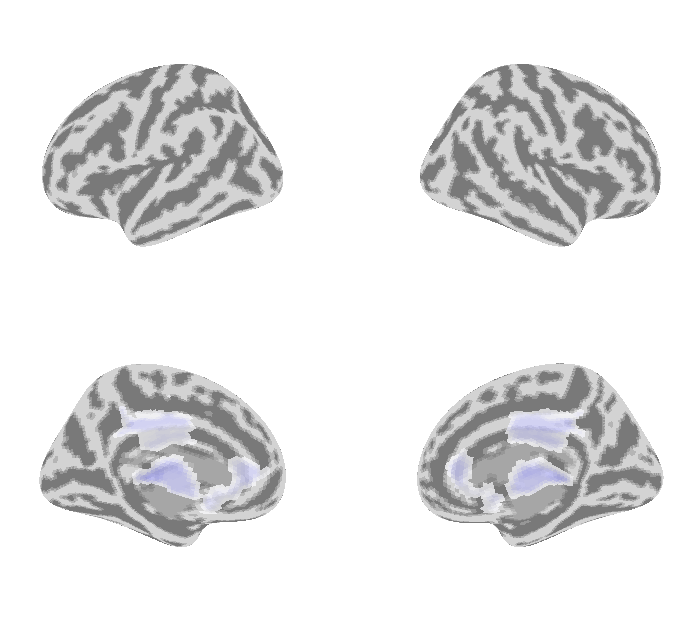

In [13]:
from nilearn.image import load_img, new_img_like
from nilearn import plotting
import cmasher as cmr
from nilearn import datasets

atlas = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
atlas_data = atlas.get_fdata()
for idx_state in range(K):
    attractor = avg_attractors[idx_state,:]
    print(np.max(np.abs(attractor)))
    img_data = np.zeros_like(atlas_data)
    for idx_roi in range(1,N+1):
        img_data += (atlas_data==idx_roi)*attractor[idx_roi-1]
    img = new_img_like(ref_niimg=atlas,data=img_data, affine=None,copy_header=True)
    fig,ax = plotting.plot_img_on_surf(
        img,
        surf_mesh='fsaverage5',
        mask_img=None,
        hemispheres=['left','right'],
        bg_on_data=True,
        inflate=True,
        views=['lateral','medial'],
        output_file=None,
        title='',
        colorbar=False,
        vmax=1,#np.max(np.abs(attractor)),
        threshold=1e-3,
        symmetric_cbar=False,
        cmap='seismic',#cmr.pride,
        colorbar_fontsize=100
    )
    fig.set_size_inches(10.5, 10.5)
    fig.savefig(f'figures/fig_attractor{idx_state}_K{K}_D{D}_N{N}_{num_subjs}subjs.eps',dpi=600,bbox_inches='tight')
        


0.025256228158178174 -1.0076240503167366
0.9867038138811088 -0.3475489068193018
0.533839105095082 -0.11025190418388105
0.8021984095421495 -0.8549028271358795
0.4744047238221572 -0.5422192496871402


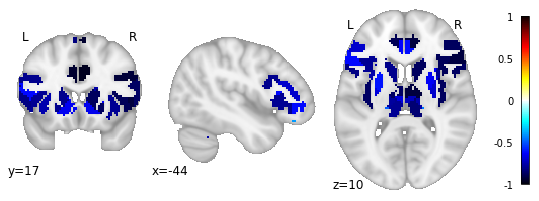

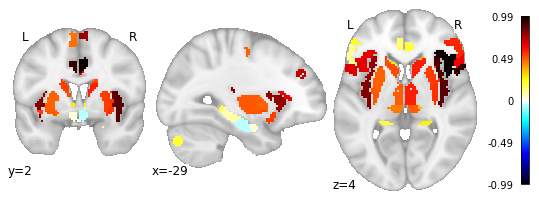

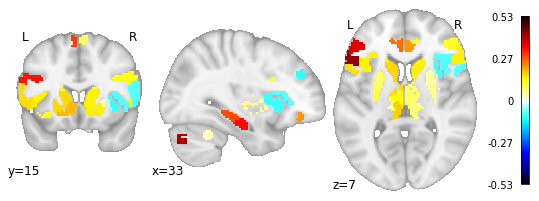

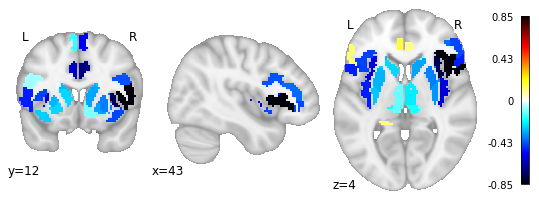

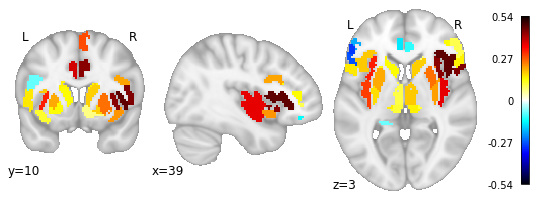

In [11]:
from nilearn.image import load_img, new_img_like
from nilearn import plotting
import cmasher as cmr
from nilearn import datasets

atlas = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
underlay = load_img('/home/joyneelm/templates/MNI152_T1_1mm_brain_01132017.nii.gz')
atlas_data = atlas.get_fdata()
for idx_state in range(K-1):
    attractor = avg_attractors[idx_state,:]
    img_data = np.zeros_like(atlas_data)
    for idx_roi in range(1,N+1):
        img_data += (atlas_data==idx_roi)*attractor[idx_roi-1]
    img = new_img_like(ref_niimg=atlas,data=img_data, affine=None,copy_header=True)
    print(np.max(attractor), np.min(attractor))
    plotting.plot_stat_map(
        img,
        bg_img=underlay,
        cmap='cold_white_hot',
        draw_cross=False,
        black_bg=False,
        # symmetric_cbar=True,
        # vmax=1,vmin=-1,
        # dim=-2,
    )
        


In [ ]:
bg_maps = {'left':fsaverage.sulc_left,'right':fsaverage.sulc_right}

for idx_state in range(K):

    attractor = avg_attractors[idx_state,:]
    print(np.max(np.abs(attractor)))
    img_data = np.zeros_like(atlas_data)

    for idx_roi in range(1,N+1):
        img_data += (atlas_data==idx_roi)*attractor[idx_roi-1]
    img = new_img_like(ref_niimg=atlas,data=img_data, affine=None,copy_header=True)
    
    for hemi in ['left', 'right']:
        txture = surface.vol_to_surf(img,fs_surf[hemi])
        for view in ['lateral', 'medial']:

            # txture = surface.vol_to_surf(img, fs_surf[hemi],kind='ball')
            # fig = plotting.plot_surf_stat_map(
            #     fs_surf[hemi],
            #     txture,
            #     hemi=hemi,
            #     view=view,
            #     colorbar=False, 
            #     threshold=1e-3,
            #     bg_map=bg_maps[hemi])
    
            fig,ax = plotting.plot_img_on_surf(
                img,
                surf_mesh=fsaverage,
                mask_img=None,
                hemispheres=[hemi],
                bg_on_data=True,
                inflate=True,
                views=[view],
                output_file=None,
                title='',
                colorbar=False,
                vmax=1,#np.max(np.abs(attractor)),
                threshold=1e-3,
                symmetric_cbar=False,
                cmap='seismic',#cmr.pride,
                colorbar_fontsize=100
            )
    
            for idx_roi in range(85):
                if attractor[idx_roi]==0: continue
                plotting.plot_surf_contours(
                    fs_surf[hemi],
                    textures[hemi][idx_roi],
                    labels=['roi'],
                    levels=[0],
                    figure=fig,
                    legend=False,
                    colors=['k']
                )

        
        
            fig.set_size_inches(10.5, 10.5)
        
